In [1]:
# from zeno_client import ZenoClient, ZenoMetric
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.cm import get_cmap
sys.path.append('../')
from file_utils import load_json


root_dir = os.getenv('reader_results_dir')
top_k_results_dir = os.path.join(root_dir, 'top_k')
top_neg_results_dir = os.path.join(root_dir, 'top_negative')
top_pos_results_dir = os.path.join(root_dir, 'top_positive')

cmap = plt.colormaps['tab10']  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list


1. Load all the dataframes in 1a. If it doesn't exist, run 1b.

2. Plot the figures. You can customize dataset, reader_metric, slice, reader_models, retriever_models...etc.

    2a. Plot all instances

    2b. Plot gold/no gold par found

    2c. Plot baselines (gold, no-context)

    2d. Plot by question category


# 1a. Load dataframes

In [3]:
import pickle
import os
reader_models = ['flanUl2', 'llama_70b', 'flanT5', 'llama_7b']
retriever_models = ['colbert','gold', 'bm25']
top_ks= ["baseline", "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]

with open(os.path.join(os.getenv('DBQA'), 'combined_zeno.pkl'), 'rb') as f:
    output_by_dataset = pickle.load(f)

with open(os.path.join(os.getenv('DBQA'), 'noisy_combined_zeno.pkl'), 'rb') as f:
    noisy_output_by_dataset = pickle.load(f)

with open(os.path.join(os.getenv('DBQA'), 'clean_combined_zeno.pkl'), 'rb') as f:
    clean_output_by_dataset = pickle.load(f)

# 1a. Create and save dataframe compilation

In [ ]:
from zeno_upload import get_precision, get_recall, combine_gold_and_compiled, get_reader_df

In [ ]:
def compile_dfs(k_subset, datasets, reader_models, retriever_models):
    top_ks= ["baseline" "top1", "top2", "top3", "top5", "top10", "top20", "top30", "top50"]
    if k_subset == 'top_positive' or k_subset == 'top_negative':
        top_ks = top_ks[1:]
        
    output_by_dataset = {}
    data_dir = os.getenv('data_dir')
    corpus_dir = os.getenv('corpus_dir')
    
    for dataset in datasets:
        if dataset == 'bioasq':
            corpus = 'pubmed'
        else:
            corpus = 'wiki'

        id2title = load_json(os.path.join(corpus_dir, corpus, 'id2title.json'))

        gold_data = load_json(os.path.join(data_dir, 'gold_zeno_files', f"gold_{dataset}_zeno_file.json"), sort_by_id = True)

        questions_categorized = load_json(os.path.join(data_dir, f'questions_categorized/{dataset}_questions_categorized.json'))

        if dataset not in output_by_dataset.keys():
            output_by_dataset[dataset] = {}

        for retriever_model in retriever_models:
            for reader_model in reader_models:
                if reader_model not in output_by_dataset[dataset].keys():
                    output_by_dataset[dataset][reader_model] = {}

                    
            
                print('retriever', retriever_model)
                print('reader', reader_model)
                if retriever_model == 'gold':

                    data = load_json(os.path.join(dir, reader_model, dataset, 'gold', "reader_results_zeno.json"))
                            
                    combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                    output_df = get_reader_df('gold', combined_data, 'bioasq' in dataset)
                    output_by_dataset[dataset][reader_model]['gold'] = output_df
                else:
                    for top_k in top_ks:
                        print(top_k)
                        data = load_json(os.path.join(dir, reader_model, dataset, retriever_model, f"{top_k}/reader_results_zeno.json"))
                                
                        combined_data = combine_gold_and_compiled(data, gold_data, questions_categorized,'bioasq' in dataset)
                        output_df = get_reader_df(top_k, combined_data, 'bioasq' in dataset)
                        if output_by_dataset[dataset][reader_model].get(retriever_model, None) == None:
                            output_by_dataset[dataset][reader_model][retriever_model] = {}

                        if top_k == 'baseline':
                            output_by_dataset[dataset][reader_model]['no_context'] = output_df
                        else:
                            output_by_dataset[dataset][reader_model][retriever_model][top_k] = output_df
    return output_by_dataset

In [ ]:
import pickle

k_subset = 'top_k'
top_k_results_dir = compile_dfs(k_subset, datasets, reader_models, retriever_models)
with open(os.path.join(root_dir, f'{k_subset}_compiled_dfs.pkl'), 'wb') as outp:
    pickle.dump(top_k_results_dir, outp)

k_subset = 'top_positive'
top_pos_results_dir = compile_dfs(k_subset, datasets, reader_models, retriever_models)
with open(os.path.join(root_dir, f'{k_subset}_compiled_dfs.pkl'), 'wb') as outp:
    pickle.dump(top_pos_results_dir, outp)

k_subset = 'top_negative'
top_neg_results_dir = compile_dfs(k_subset, datasets, reader_models, retriever_models)
with open(os.path.join(root_dir, f'{k_subset}_compiled_dfs.pkl'), 'wb') as outp:
    pickle.dump(top_neg_results_dir, outp)

# 2a. Plot all instances 

colbert_flanT5 = [0.338385618611209, 0.3782164258019034, 0.3986605569263306, 0.4173422629538245, 0.42791681353542477, 0.4462460345435319, 0.4391963341557984, 0.4391963341557984]
colbert_flanUl2 = [0.34966513923158266, 0.38667606626718365, 0.4092351075079309, 0.4258019034191047, 0.44131124427211843, 0.44836094465985193, 0.44906591469862533, 0.4518857948537187]
colbert_llama_70b = [0.3560098695805428, 0.3538949594642228, 0.36728939020091644, 0.36905181529784986, 0.3605921748325696, 0.3151216073316884, 0.263306309481847, 0.22488544236869934]
colbert_llama_7b = [0.29221008107155444, 0.28974268593584773, 0.27775819527670076, 0.24427211843496652, 0.19034191046880508, 0.13676418752203032, 0.12054987663024322, 0.11455763130066972]
bm25_flanT5 = [0.16743038420867112, 0.1931617906238985, 0.21713077194219246, 0.2506168487839267, 0.2957349312654212, 0.34367289390200917, 0.35424744448360945, 0.3605921748325696]
bm25_flanUl2 = [0.17448008459640466, 0.19633415579837857, 0.2195981670778992, 0.25096933

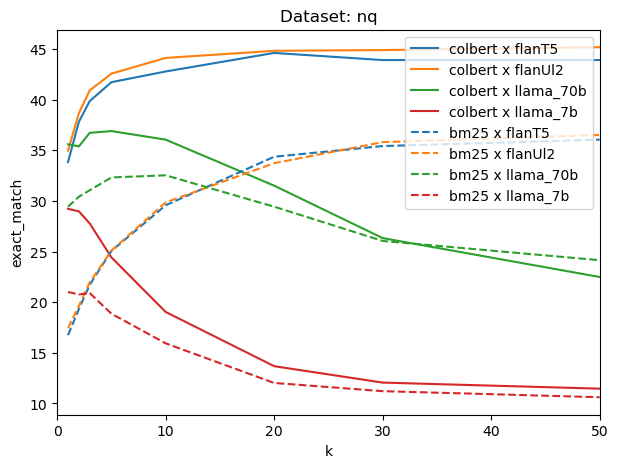

In [ ]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retrievers = ['colbert', 'bm25']
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
dataset = 'nq'
reader_metric = 'exact_match'
output_dfs = top_k_results_dir[dataset]

plt.figure(figsize=(7, 5))
for retriever in retrievers:
    for r, reader_model in enumerate(reader_models):
        if 'truncation' in reader_model:
            continue
        reader_perf_by_k = []
        for i, top_k in enumerate(ks):
            k_df =output_dfs[reader_model][retriever][top_k]
            slice_df = k_df
            reader_perf_by_k.append(np.mean(slice_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
            
            if '7b' in reader_model:
                color = colors[3]
            elif '70b' in reader_model:
                color = colors[2]
            else:
                color = colors[r%len(reader_models)]
            if retriever == 'bm25':
                linestyle = linestyles[1]
            else:
                linestyle = linestyles[0]

        plt.plot(ks, 100*np.array(reader_perf_by_k), label = f'{retriever} x {reader_model}', color = color, linestyle = linestyle)

plt.title(f'Dataset: {dataset}')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.xlim(left = min(ks), right = max(ks))
plt.legend()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

# 2b. Plot gold par found/no gold par found

nq substring_match
flanT5
top_k, 84.375, 76.03143418467585, 74.22334172963896, 72.337383845604, 69.11150864639237, 67.05446853516658, 65.32937097573055, 63.78026070763501, 
no context, 20.59659090909091, 22.20039292730845, 22.670025188916874, 23.230879199428163, 23.673225998807393, 23.9555790586991, 23.576027736503217, 23.277467411545626, 
top_positive, 84.375, 84.28290766208252, 84.2989084802687, 83.77412437455325, 82.7072152653548, 82.33738762559493, 81.67409608717186, 80.77281191806331, 
flanUl2
top_k, 83.66477272727273, 77.01375245579568, 76.0705289672544, 73.05218012866334, 69.3500298151461, 66.79005817028028, 65.32937097573055, 63.87337057728119, 
no context, 30.53977272727273, 30.746561886051083, 31.150293870696892, 31.308077197998568, 32.49850924269529, 32.41671073506082, 32.29321446260525, 31.843575418994412, 
top_positive, 83.66477272727273, 84.9705304518664, 85.13853904282117, 84.91779842744818, 83.95945140131187, 83.50079323109466, 82.76374442793461, 82.21601489757914, 


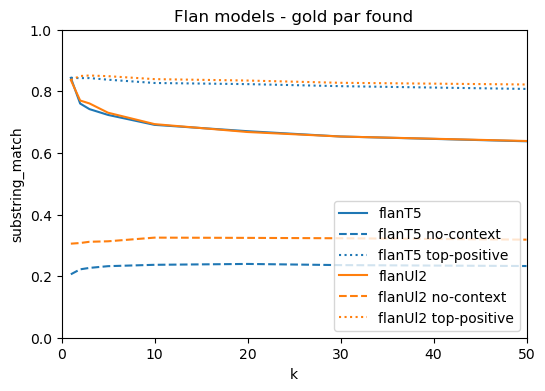

llama_70b
top_k, 75.14204545454545, 68.56581532416503, 67.33837111670866, 65.47533952823446, 60.16696481812761, 53.781068217874136, 46.012877662209014, 41.38733705772812, 
no context, 51.13636363636363, 52.357563850687626, 51.385390428211586, 50.822015725518234, 50.68574836016696, 50.76679005817029, 50.71817731550272, 50.37243947858473, 
top_positive, 75.14204545454545, 76.71905697445972, 76.2384550797649, 76.4832022873481, 74.95527728085868, 75.19830777366472, 74.83902922238732, 74.30167597765363, 
llama_7b
top_k, 65.625, 59.921414538310415, 55.499580184718724, 49.035025017869906, 41.02564102564102, 34.00317292437863, 30.65874195146112, 28.212290502793298, 
no context, 32.528409090909086, 34.18467583497053, 34.25692695214106, 33.45246604717656, 34.4066785927251, 35.007932310946586, 35.0668647845468, 34.82309124767225, 
top_positive, 65.625, 66.60117878192534, 66.16288832913519, 66.19013581129379, 65.17590936195587, 65.15071390798519, 65.27984150569588, 64.94413407821229, 


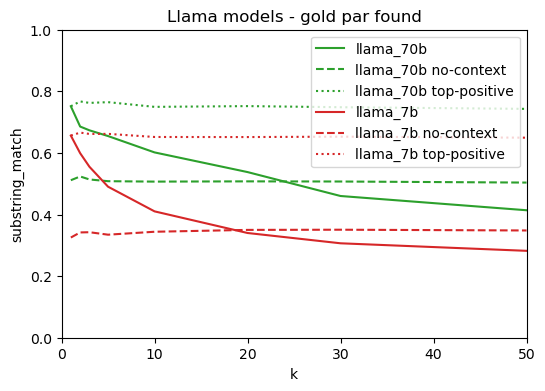

In [45]:
# for those with no gold par found, what is the baseline performance?

linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]

dataset = 'nq'
reader_metric = 'substring_match'
print(dataset, reader_metric)


readers_perf = {}
for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(ks):
        readers_perf[reader_model][top_k] = {}

        # get the slice where top_k does find a paragraph match
        k_df =top_k_results_dir[dataset][reader_model][retriever][top_k]
        slice = k_df[f'any page_par_id_match'] == True
        slice_df = k_df.loc[slice]

        # get the no context results on this slice
        no_context_df = top_k_results_dir[dataset][reader_model]['no_context']
        no_context_df = no_context_df.loc[slice]
        readers_perf[reader_model][top_k][reader_metric] = np.mean(slice_df[reader_metric].values)
        readers_perf[reader_model][top_k][f'no-context {reader_metric}'] = np.mean(no_context_df[reader_metric].values)
        
        # get the top positive results on this slice
        top_pos_df = top_pos_results_dir[dataset][reader_model][retriever][top_k]
        top_pos_df = top_pos_df.loc[slice]
        readers_perf[reader_model][top_k]['top-positive {reader_metric}'] = np.mean(top_pos_df[reader_metric].values)
        

for i, (r, top_kdict) in enumerate(readers_perf.items()):
    if 'truncation' in r:
        continue
    top_k_f1s = []
    no_context_f1s = []
    top_pos_f1s = []
    ks = []
    for top_k, value_dict in top_kdict.items():
        ks.append(int(top_k.split('_')[1]))
        top_k_f1s.append(value_dict[reader_metric])
        no_context_f1s.append(value_dict[f'no-context {reader_metric}'])
        top_pos_f1s.append(value_dict[f'top-positive {reader_metric}'])
    
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[i%len(reader_models)]

    plt.plot(ks, top_k_f1s, color = color, label = f'{r}')
    plt.plot(ks, no_context_f1s, color = color, linestyle = '--', label = f'{r} no-context')
    plt.plot(ks, top_pos_f1s, color = color, linestyle = ':', label = f'{r} top-positive')

    ytop = 1
    ybot = 0
    
    if r == 'flanUl2':
        plt.title(f'Flan models - gold par found')
        plt.legend()
        plt.ylim(bottom = ybot, top = ytop)
        plt.xlim(left = 1, right = 50)
        plt.xlabel('k')
        plt.ylabel(reader_metric)
        # plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_flan_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.figure(figsize = (6,4))
  
plt.title(f'Llama models - gold par found')
plt.legend()
plt.ylim(bottom = ybot, top = ytop)
plt.xlim(left = 1, right = 50)
plt.xlabel('k')
plt.ylabel(reader_metric)
# plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_llama_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
plt.show()

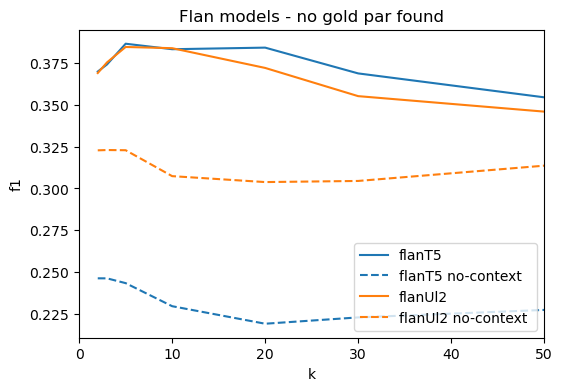

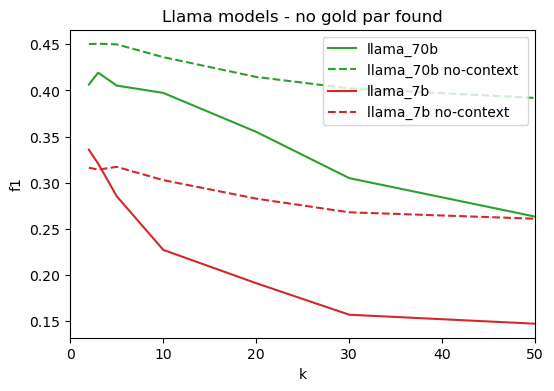

In [59]:
# for those with no gold par found, what is the baseline performance?

linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]

dataset = 'nq'
reader_metric = 'substring_match'
print(dataset, reader_metric)


readers_perf = {}
for r, reader_model in enumerate(reader_models):
    readers_perf[reader_model] = {}
    if 'truncation' in reader_model:
        continue
    reader_perf_by_k = []
    for i, top_k in enumerate(ks):
        readers_perf[reader_model][top_k] = {}

        # get the slice where top_k does find a paragraph match
        k_df =top_k_results_dir[dataset][reader_model][retriever][top_k]
        slice = k_df[f'any page_par_id_match'] == False
        slice_df = k_df.loc[slice]

        # get the no context results on this slice
        no_context_df = top_k_results_dir[dataset][reader_model]['no_context']
        no_context_df = no_context_df.loc[slice]
        readers_perf[reader_model][top_k][reader_metric] = np.mean(slice_df[reader_metric].values)
        readers_perf[reader_model][top_k][f'no-context {reader_metric}'] = np.mean(no_context_df[reader_metric].values)
        

for i, (r, top_kdict) in enumerate(readers_perf.items()):
    if 'truncation' in r:
        continue
    top_k_f1s = []
    no_context_f1s = []
    top_pos_f1s = []
    ks = []
    for top_k, value_dict in top_kdict.items():
        ks.append(int(top_k.split('_')[1]))
        top_k_f1s.append(value_dict[reader_metric])
        no_context_f1s.append(value_dict[f'no-context {reader_metric}'])
    
    if '7b' in r:
        color = colors[3]
    elif '70b' in r:
        color = colors[2]
    else:
        color = colors[i%len(reader_models)]

    plt.plot(ks, top_k_f1s, color = color, label = f'{r}')
    plt.plot(ks, no_context_f1s, color = color, linestyle = '--', label = f'{r} no-context')

    ytop = 1
    ybot = 0
    
    if r == 'flanUl2':
        plt.title(f'Flan models - no gold par found')
        plt.legend()
        plt.ylim(bottom = ybot, top = ytop)
        plt.xlim(left = 1, right = 50)
        plt.xlabel('k')
        plt.ylabel(reader_metric)
        # plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_flan_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.figure(figsize = (6,4))
  
plt.title(f'Llama models - no gold par found')
plt.legend()
plt.ylim(bottom = ybot, top = ytop)
plt.xlim(left = 1, right = 50)
plt.xlabel('k')
plt.ylabel(reader_metric)
# plt.savefig(os.path.join(os.getenv('DBQA'), 'figs', f'{dataset}_llama_gold_par_found_{reader_metric}.pdf'),bbox_inches='tight', pad_inches=0)
plt.show()

# 2c. Plot baseline performances

flanT5
gold 0.673598872047938
no_context 0.1663729291505111

flanUl2
gold 0.6813535424744448
no_context 0.23545999295029962

llama_70b
gold 0.5576313006697216
no_context 0.34085301374691573

llama_70b_2000_truncation
llama_7b
gold 0.43637645400070496
no_context 0.2150158618258724

llama_7b_2000_truncation


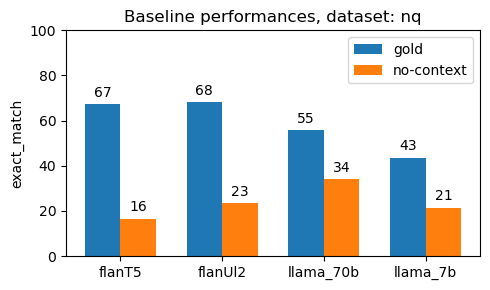

In [84]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
retriever = 'colbert'
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]
dataset = 'nq'
reader_metric = 'exact_match'
gold_perf = []
no_context_perf = []

output_dfs = top_k_results_dir[dataset]
for r, reader_model in enumerate(reader_models):
    print(reader_model)
    if 'truncation' in reader_model:
        continue
    for i, baseline in enumerate(['gold', 'no_context']):
        k_df =output_dfs[reader_model][baseline]
        slice_df = k_df # CAN CHANGE SLICE CONDITION HERE
        reader_perf = np.mean(slice_df[reader_metric].values) # CAN CHANGE READER METRIC HERE
        print(baseline, reader_perf)
        if baseline == 'gold':
            gold_perf.append(reader_perf)
        else:
            no_context_perf.append(reader_perf)
    print()

n_models = len(reader_models)

x = np.arange(len(reader_models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(5,3))

gold_plot = ax.bar(x - width/2, 100*np.array(gold_perf), width, label='gold')
no_context_plot = ax.bar(x + width/2, 100*np.array(no_context_perf), width, label='no-context')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(reader_metric)
ax.set_title(f'Baseline performances, dataset: {dataset}')
ax.set_xticks(x)
ax.set_xticklabels(reader_models)
ax.legend()
ax.set_ylim(bottom= 0, top = 100)

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(int(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(gold_plot)
autolabel(no_context_plot)
plt.tight_layout()
plt.show()



# 2d Plot by slice - Question Category
Change question_category, dataset, or reader_metric as you see fit

flanT5 colbert
0.3536617148814178
flanUl2 colbert
llama_70b colbert
llama_7b colbert


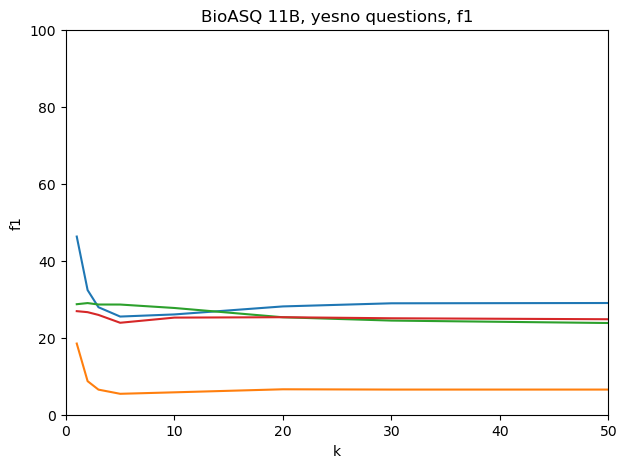

In [92]:
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^', 'D', 'v', 'p']
ks = [1, 2, 3, 5, 10 , 20 , 30 , 50]

plt.figure(figsize=(7, 5))

dataset = 'bioasq'
output_dfs = top_k_results_dir[dataset]
print_slice_size = True
reader_metric = 'f1'
question_category = 'yesno'
for r, reader_model in enumerate(reader_models):
    for r2, retriever_model in enumerate(['colbert']):
        print(reader_model, retriever_model)
        reader_perf_by_k = []
        for i, top_k in enumerate(ks):
            k_df =output_dfs[reader_model][retriever_model][top_k]
            slice_df = k_df.loc[k_df['question_category'] == question_category]
            reader_perf_by_k.append(np.mean(slice_df[reader_metric].values)) # CAN CHANGE READER METRIC HERE
            print(f'size of category {question_category}: {len(slice_df)/len(k_df)}')

        if '7b' in reader_model:
            color = colors[3]
        elif '70b' in reader_model:
            color = colors[2]
        else:
            color = colors[r%len(reader_models)]
        plt.plot([1, 2, 3, 5, 10 , 20 , 30 , 50], 100*np.array(reader_perf_by_k), label = f'{reader_model}', color = color, linestyle = linestyles[r2])

plt.title(f'{dataset}, {question_category} questions, {reader_metric}')

plt.xlabel('k')
plt.ylabel(reader_metric)
plt.ylim(top = 100, bottom = 0.0)
plt.xlim(left = 0, right = 50)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()